#### Several brands' representatives which sell their goods via our platform are going to launch a loyalty program. The program is aimed to reward the most loyal customers and give them additional discount cards. What you need to to is the following:
    1) Analyze the logs of sales on our platform
    2) Propose a method of revealing most loyal customers based on the analyzed data
    3) Determine the users

## Data preparation and analysis

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
df = pd.read_csv('C://Users/psy_f/Desktop/analytics/python/custloyalty.csv', encoding = 'windows-1251')

In [76]:
df.head(5)

,Unnamed: 0,tk,pl,dia,hs,tc,cta,id_art,id_subsubfam,id_subfam,...,id_famn,id_seccion,id_subagr,id_agr,vta,uni,id_artn,art_sp,fam_sp,fam_en
0,1242,120071109002055793,1,2007/11/09,0.505729,110000761,11000076,21895,101070640100,1010706401,...,10107064,10107,101,1,0.68,1.0,21895,MARAVILLA 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
1,1243,120070601004053633,1,2007/06/01,0.588519,110000761,11000076,21816,101070640100,1010706401,...,10107064,10107,101,1,0.38,1.0,21816,FIDEO CABELLIN 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
2,1244,120070928004076410,1,2007/09/28,0.785498,28491841,2849184,562840,101070640100,1010706401,...,10107064,10107,101,1,1.55,2.0,562840,SPAGUETTI Nє 5 500 G Brand_1,PASTA ALIMENTICIA SE,pasta
3,1245,120070616003074261,1,2007/06/16,0.550961,95931501,9593150,28914,101070640100,1010706401,...,10107064,10107,101,1,1.03,2.0,28914,FIDEO FIDEUБ 500 Brand_7,PASTA ALIMENTICIA SE,pasta
4,1246,120070519001018477,1,2007/05/19,0.804954,93265591,9326559,159867,101070640100,1010706401,...,10107064,10107,101,1,1.09,1.0,159867,MACARRONES GRATINAR 5 Brand_2,PASTA ALIMENTICIA SE,pasta


In [77]:
user_df = df[['tc','art_sp']]
user_df = user_df.rename (columns = {'tc':'user_id','art_sp':'brand_info'})
user_df.head(10)

,user_id,brand_info
0,110000761,MARAVILLA 500 G Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2
5,93265591,SPAGUETI PLATOS 500 G Brand_2
6,110002291,SPAGHETTINI 500 G Store_Brand
7,720501,SPAGHETTI 500 G Store_Brand
8,2415351,SPAGHETTI 500 G Brand_3
9,110016541,SPAGHETTI 500 G Store_Brand


From the table above we can see that in column 'brand_info' the actual brand name is included in the last part of a string. For example, in line 0 the product belongs to a brand name 'Store_Brand'. Thus, firstly, we need to split the string in order to analyse the brand names separately.

In [78]:
user_df['brand_name'] = user_df.brand_info.apply(lambda x: x.split(' ')[-1])
user_df.head(5)

,user_id,brand_info,brand_name
0,110000761,MARAVILLA 500 G Store_Brand,Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1,Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7,Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2,Brand_2


After that what I am going to do is to aggregate the number of purchases by users. The table description gives us an information about a number of unique users (11764 users) and a distribution of number of purchases. In fact, the most useful info is that 75% of users made 5 and above purchases. Let us analyse this part of users more deeply.

In [79]:
users_purchases = user_df.groupby('user_id', as_index = False) \
.agg({'brand_name':'count'}) \
.rename(columns = {'brand_name':'purchases'})
users_purchases.describe()

,user_id,purchases
count,1.176400e+04,11764.000000
mean,7.690517e+07,4.091210
std,1.622210e+08,4.573143
min,-1.236395e+09,1.000000
25%,1.503761e+07,1.000000
50%,4.682179e+07,2.000000
75%,9.311601e+07,5.000000
max,1.408849e+09,60.000000


## Determining the most loyal users

In [80]:
users_purchases = user_df.groupby('user_id', as_index = False) \
.agg({'brand_name':'count'}) \
.rename(columns = {'brand_name':'purchases'}) \
.query ('purchases >= 5')
users_purchases.head(5)

,user_id,purchases
1,1031,6
2,4241,5
11,25971,7
14,40911,27
16,45181,5


However, a number of purchases by user does not give us a base for our decision as the number of purchases in total might be distributed between different brands. In that case a user is not supposed to be loyal to a distinct brand as the purchases seem to occasional. Further analysis should include a finding of a share of purchases of the user's favourite brand. 

In [81]:
# for every user we have calculated number of purchases of favourite brand
lovely_brand_purchases_df = \
        user_df.groupby(['user_id','brand_name'], as_index = False) \
        .agg ({'brand_info':'count'}) \
        .sort_values(['user_id','brand_info'], ascending = [False, False]) \
        .groupby('user_id') \
        .head(1) \
        .rename (columns = {'brand_name':'lovely_brand','brand_info':'lovely_brand_purchases'})

In [82]:
# for every user we have calculated total number of purchases
users_unique_brands = \
    user_df.groupby('user_id',as_index = False) \
    .agg({'brand_name': pd.Series.nunique}) \
    .rename(columns={'brand_name':'unique_brands'})

Now we are merging the two dataframes and calculating for every user the loyalty coefficient as purchases of favourite brand divided by total purchases:

In [83]:
loyalty_df = users_purchases \
    .merge(users_unique_brands, on = 'user_id') \
    .merge(lovely_brand_purchases_df, on = 'user_id')
loyalty_df['loyalty_score'] = loyalty_df.lovely_brand_purchases / loyalty_df.purchases
loyalty_df.head(5)

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases,loyalty_score
0,1031,6,2,Store_Brand,5,0.833333
1,4241,5,2,Brand_4,3,0.600000
2,25971,7,2,Store_Brand,5,0.714286
3,40911,27,5,Brand_4,19,0.703704
4,45181,5,4,Store_Brand,2,0.400000


After that, if we are filtering the dataset of those users who have only one unique brand in their purchase history we can get the most loyal users who made 5 and more purchases and all of the transactions are related to their one most lovely brand. The total number of such users is 911.

In [84]:
loyal_users = loyalty_df[loyalty_df.unique_brands == 1]
loyal_users

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases,loyalty_score
13,86281,14,1,Brand_4,14,1.0
18,94961,6,1,Brand_4,6,1.0
29,132061,9,1,Brand_4,9,1.0
30,134281,6,1,Brand_4,6,1.0
35,157311,12,1,Brand_4,12,1.0
...,...,...,...,...,...,...
3372,1010244089,9,1,Store_Brand,9,1.0
3374,1010247239,5,1,Brand_4,5,1.0
3376,1010274559,5,1,Brand_4,5,1.0
3377,1110091379,5,1,Brand_1,5,1.0


## Determining the most popular brands with the highest users' loyalty

In [85]:
brand_loyalty = loyalty_df.groupby('lovely_brand', as_index = False) \
    .agg({'user_id':'count'}) \
    .sort_values('user_id', ascending = False)

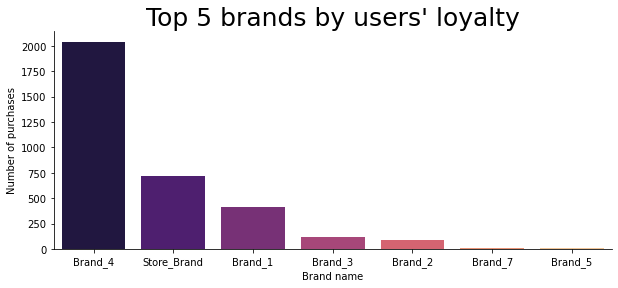

In [86]:
plt.figure(figsize=(10,4))
ax = sns.barplot \
    (x = "lovely_brand" \
    ,y = "user_id" \
    ,data = brand_loyalty \
    ,palette='magma')
plt.title("Top 5 brands by users' loyalty", size=25)
plt.ylabel('Number of purchases')
plt.xlabel('Brand name')
sns.despine()

As it can be noticeable, Brand_4 is the most popular brand for the users with 100% loyalty. This might be a sign of the brand's products' quality and good pricing policy what is appreciated by the platform users.